In [1]:
import torch as tch
import numpy as np
import random
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle


import loader
import DataTools

In [2]:
# Data
dataDir = '/usr/sci/cibc/Maprodxn/ClinicalECGData/LVEFCohort/pythonData/'
with open('patient_splits/pre_train_patients.pkl', 'rb') as file:
    pre_train_patients = pickle.load(file)

dataset = DataTools.ECGDatasetLoader(baseDir=dataDir,patients=pre_train_patients.tolist(), normalize=False)

In [3]:
def visualizeLeads(data, text, original_ecg=None):
  
  x = list(range(data.shape[-1]))
  if original_ecg is not None:
    fig, axs = plt.subplots(8, 2, figsize=(2*30, 2*8*2.5))
  else:
    fig, axs = plt.subplots(8, figsize=(2*15, 2*8*2.5))
  fig.suptitle(f'{text}', fontsize=60, y=0.92)
  for lead in range(8):
      y = list(data[lead, :])
      if original_ecg is not None:
        axs[lead, 0].plot(x,y,linewidth=2)
        axs[lead, 0].set(xlabel=f'Lead {lead} ')
        axs[lead, 0].xaxis.label.set_visible(True)

        y = list(original_ecg[lead, :])
        axs[lead, 1].plot(list(range(original_ecg.shape[-1])), y, linewidth=2)
        axs[lead, 1].set(xlabel=f'Lead {lead}')
        axs[lead, 1].xaxis.label.set_visible(True)
      else:
        axs[lead].plot(x,y,linewidth=2)
        axs[lead].set(xlabel=f'Lead {lead} ')
        axs[lead].xaxis.label.set_visible(True)

  plt.subplots_adjust(hspace=0.4, wspace=0.2)
  return fig


def visualizeLeads_comp(data, text, original_ecg):
  
  fig, axs = plt.subplots(8, figsize=(4*15, 4*8*2.5))
  fig.suptitle(f'{text}', fontsize=50, y=0.92)
  pad_size = (original_ecg.shape[-1] - data.shape[-1])//2
  if pad_size != 0:
      pad = tch.full((8, pad_size), float('nan'))
      data = tch.cat((pad, data, pad), dim=1)
  
  for lead in range(8):
        y = list(data[lead, :])
        axs[lead].plot(list(range(data.shape[-1])),y,linewidth=2, color='red')
        

        y = list(original_ecg[lead, :])
        axs[lead].plot(list(range(original_ecg.shape[-1])), y, linewidth=1, color='blue', linestyle=":")
        axs[lead].set_xlabel(f'Lead {lead}',fontsize=30)
        axs[lead].xaxis.label.set_visible(True)

        axs[lead].tick_params(axis='x', labelsize=30)  # For x-axis
        axs[lead].tick_params(axis='y', labelsize=30)  # For y-axis
      

  plt.subplots_adjust(hspace=0.4, wspace=0.2)
  return fig

In [4]:
data = dataset[50]
ecg = data[0][0]
print(data[1], ecg.shape)

tensor(64.2000) torch.Size([8, 5000])


torch.Size([8, 5000])


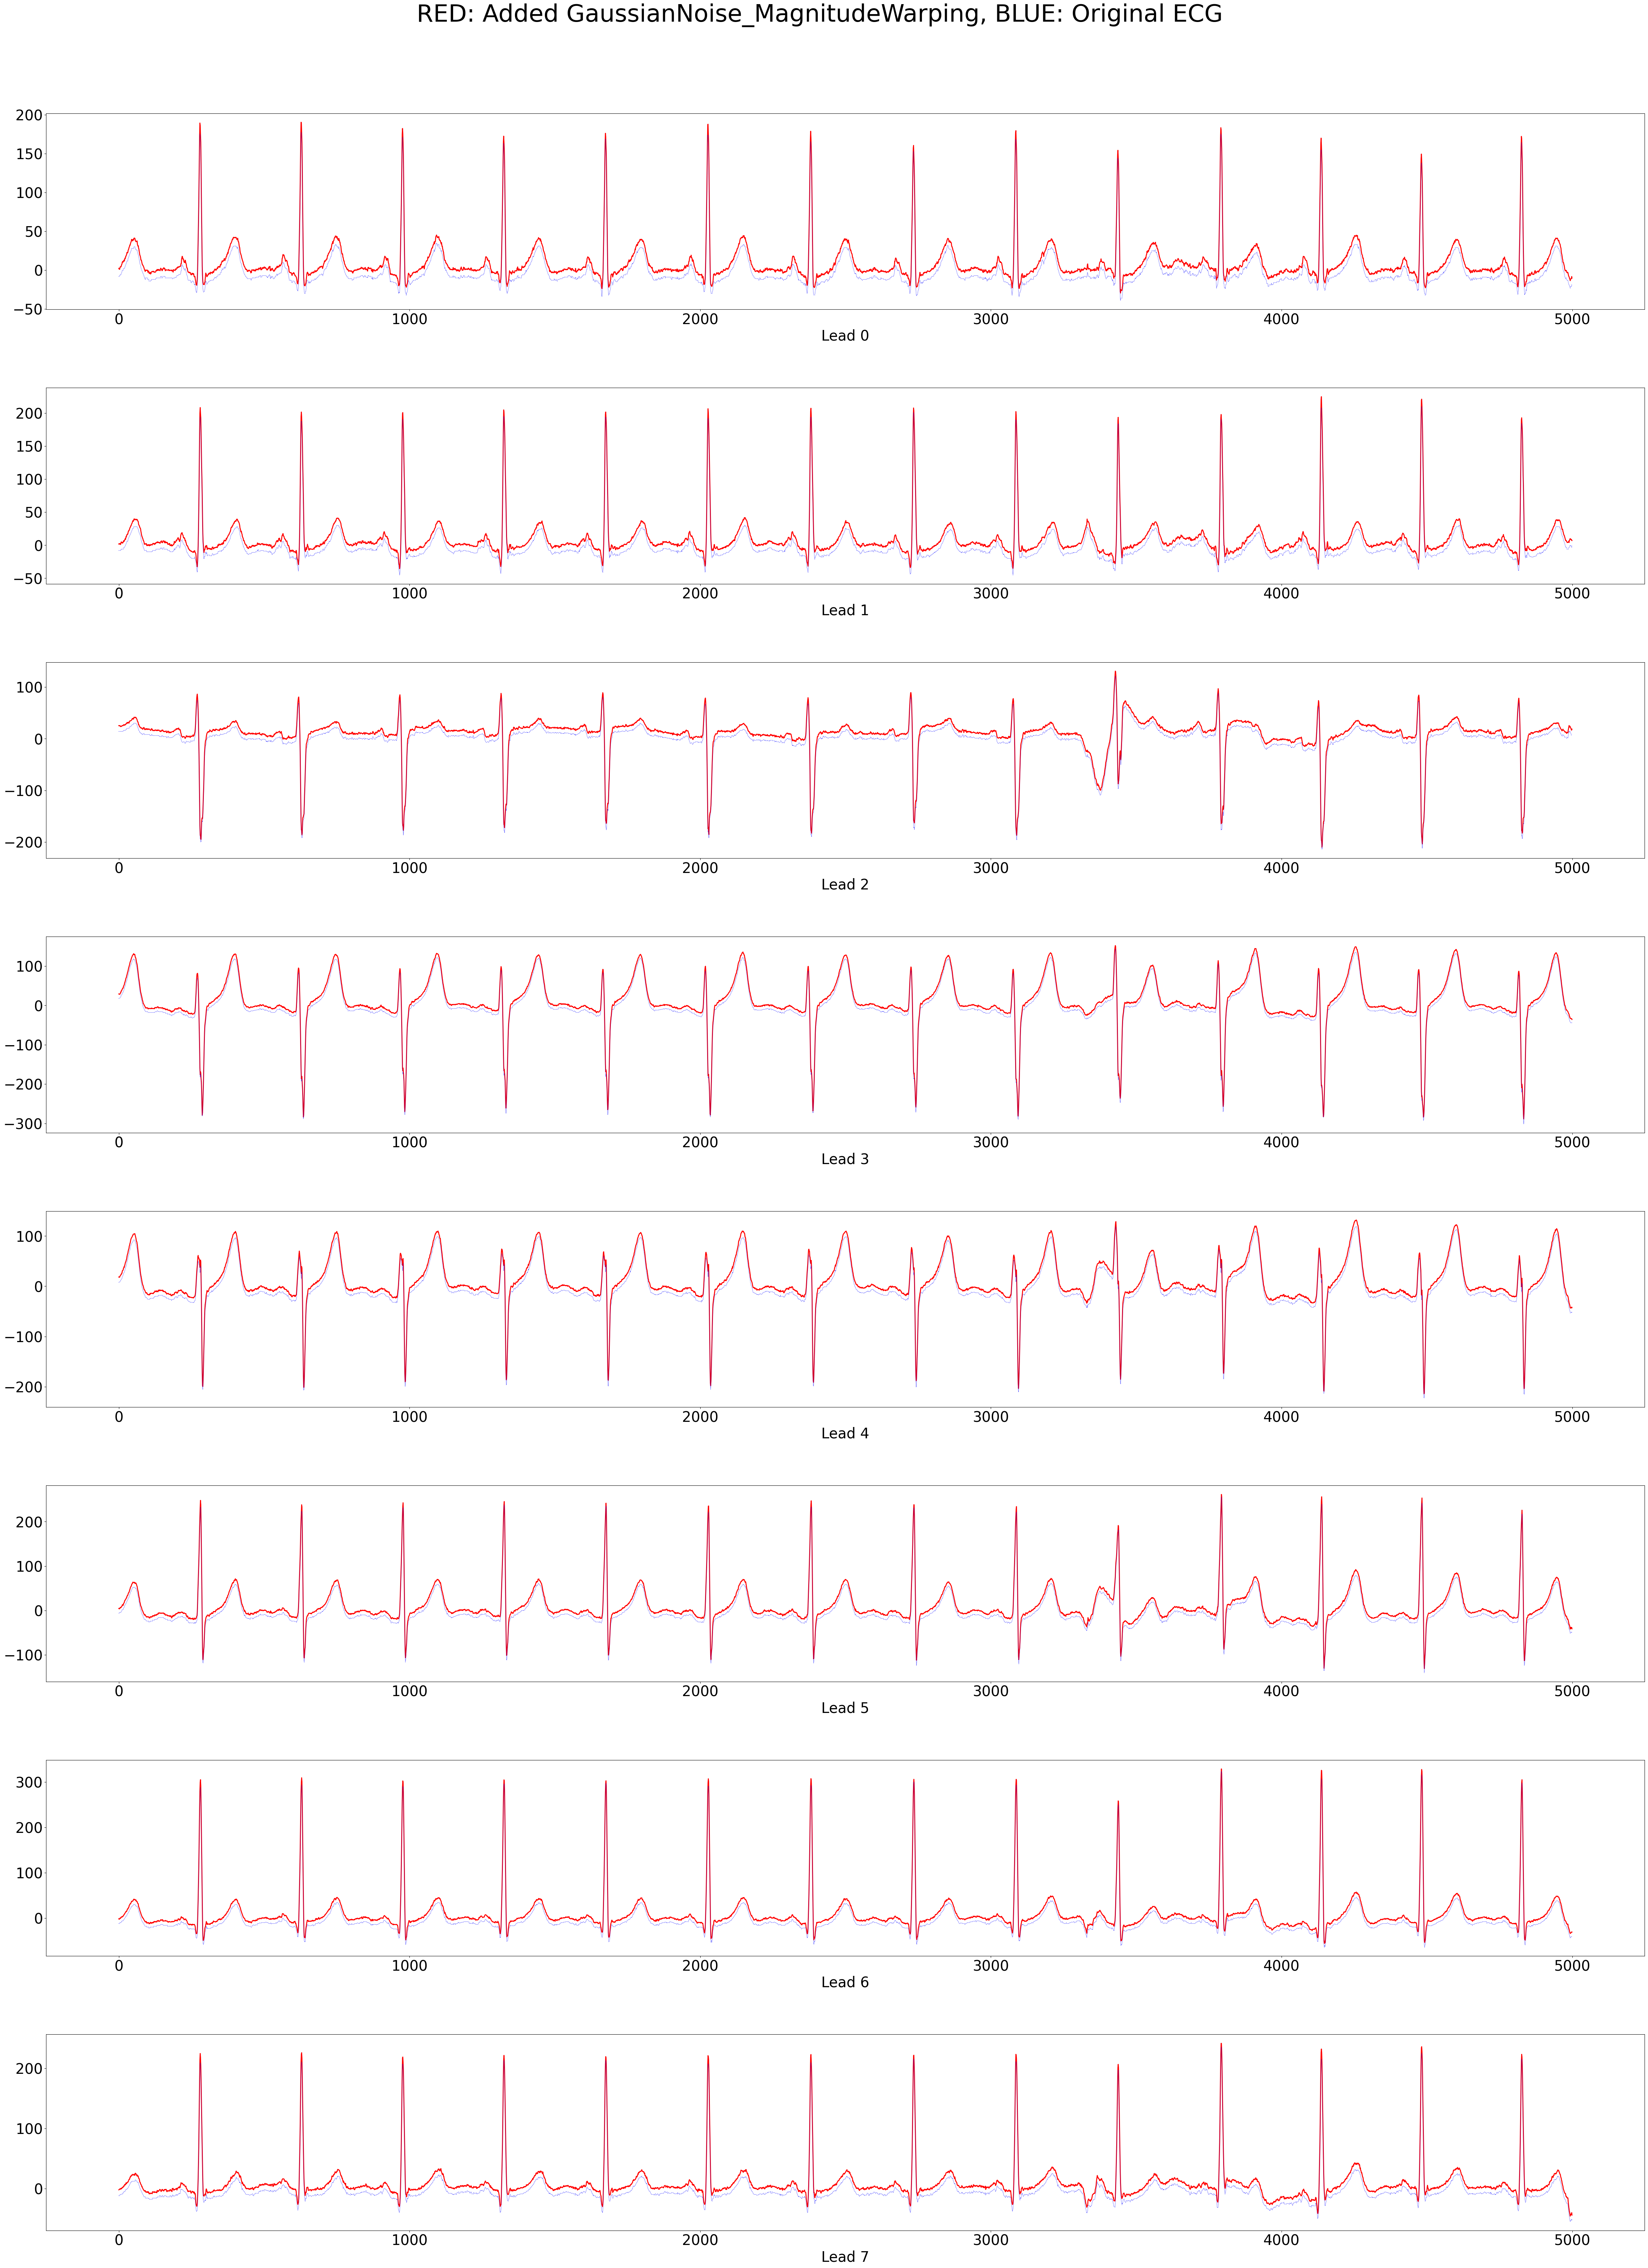

In [8]:
gaussian_noise = loader.GaussianNoise(sigma=0.5, mean=10)
MagnitudeWarping = loader.MagnitudeWarping()

augmentation = [
    gaussian_noise,
    MagnitudeWarping,
]

augmentation_name = '_'.join([str(aug.__class__.__name__) for aug in augmentation])
augs = loader.TwoCropsTransform(transforms.Compose(augmentation))
ecg = data[0][0]
mod = augs(ecg)
sig = mod[0][0]
print(sig.shape)

temp = visualizeLeads_comp(sig, f"RED: Added {augmentation_name}, BLUE: Original ECG", ecg)

In [46]:
dataDir = '/usr/sci/cibc/Maprodxn/ClinicalECGData/LVEFCohort/pythonData/'
normEcgs = False

print("Preparing Data For Classification Finetuning")
with open('patient_splits/validation_patients.pkl', 'rb') as file:
    validation_patients = pickle.load(file)

with open('patient_splits/pre_train_patients.pkl', 'rb') as file:
    pretrain_patients = pickle.load(file)

num_classification_patients = len(pretrain_patients)
finetuning_ratios = [0.01, 0.05, 0.1]
num_finetuning = [int(num_classification_patients * r) for r in finetuning_ratios]
print(f"Num of classifcation patients is {num_classification_patients} Patients split as {num_finetuning}")

random_seed_split = 1
patientInds = list(range(num_classification_patients))
random.Random(random_seed_split).shuffle(patientInds)


datasets = []
for i in num_finetuning:
    finetuning_patient_indices = patientInds[:i]

    finetuning_patients = pretrain_patients[finetuning_patient_indices].squeeze()

    dataset = DataTools.PatientECGDatasetLoader(baseDir=dataDir, patients=finetuning_patients.tolist(), normalize=normEcgs)

    datasets.append(dataset)

validation_dataset = DataTools.PatientECGDatasetLoader(baseDir=dataDir, patients=validation_patients.tolist(), normalize=normEcgs)


Preparing Data For Classification Finetuning
Num of classifcation patients is 22381 Patients split as [223, 1119, 2238]


In [47]:
def splits(dataset):
    threshold = 40.
    pos = 0
    for i in dataset:
        if i[1] < threshold:
            pos += 1
    print(f"Positives: {pos}, Negatives: {len(dataset) - pos} which is {pos/len(dataset)*100}% positives")

In [48]:
splits(datasets[0])
splits(datasets[1])
splits(datasets[2])
splits(validation_dataset)

Positives: 18, Negatives: 205 which is 8.071748878923767% positives
Positives: 87, Negatives: 1032 which is 7.774798927613941% positives
Positives: 154, Negatives: 2084 which is 6.881143878462913% positives
Positives: 210, Negatives: 2277 which is 8.443908323281061% positives
